## 1. Regression Models


In [15]:
import warnings
import os
import kaggle
import statsmodels.api as sm   # For advanced statistical modeling
import numpy as np     # For numerical computations
import pandas as pd    # For handling dataframes and data manipulation
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For enhanced visualizations
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error  # Metrics to evaluate models
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.linear_model import LinearRegression     # For linear regression model
from statsmodels.stats.outliers_influence import variance_inflation_factor  # To calculate VIF for multicollinearity
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")

### 1.1 Fetch and load data

In [5]:
# Dataset identifier from the URL
dataset = "ganjerlawrence/mobile-phone-price-prediction-cleaned-dataset"

# Directory to save the dataset
output_dir = "./kaggle_dataset"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Download the dataset
kaggle.api.dataset_download_files(dataset, path=output_dir, unzip=True)

print(f"Dataset downloaded and extracted to {output_dir}")

filename = "Mobile-Price-Prediction-cleaned_data.csv"
file_path = os.path.join(output_dir, filename)

df = pd.read_csv(file_path)
df.head()


Dataset URL: https://www.kaggle.com/datasets/ganjerlawrence/mobile-phone-price-prediction-cleaned-dataset
Dataset downloaded and extracted to ./kaggle_dataset


,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999


### 1.2 Exploratory Data Analysis 

In [6]:
# Display a summary of the Dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ratings        807 non-null    float64
 1   RAM            807 non-null    float64
 2   ROM            807 non-null    float64
 3   Mobile_Size    807 non-null    float64
 4   Primary_Cam    807 non-null    int64  
 5   Selfi_Cam      807 non-null    float64
 6   Battery_Power  807 non-null    int64  
 7   Price          807 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 50.6 KB


,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
count,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000
mean,4.112639,5.941760,64.390335,5.620660,47.821561,8.868649,3278.859975,14269.167286
std,0.367830,2.056359,53.868626,3.957409,11.155916,4.547254,937.628801,23092.739983
min,2.800000,0.000000,2.000000,2.000000,5.000000,0.000000,1020.000000,479.000000
25%,3.900000,6.000000,32.000000,4.500000,48.000000,8.000000,3000.000000,984.000000
50%,4.100000,6.000000,32.000000,4.770000,48.000000,8.000000,3000.000000,1699.000000
75%,4.400000,6.000000,64.000000,6.300000,48.000000,12.000000,3800.000000,18994.500000
max,4.800000,12.000000,256.000000,44.000000,64.000000,23.000000,6000.000000,153000.000000


In [7]:
stats = df.describe()
print(stats)


          Ratings         RAM         ROM  Mobile_Size  Primary_Cam  \
count  807.000000  807.000000  807.000000   807.000000   807.000000   
mean     4.112639    5.941760   64.390335     5.620660    47.821561   
std      0.367830    2.056359   53.868626     3.957409    11.155916   
min      2.800000    0.000000    2.000000     2.000000     5.000000   
25%      3.900000    6.000000   32.000000     4.500000    48.000000   
50%      4.100000    6.000000   32.000000     4.770000    48.000000   
75%      4.400000    6.000000   64.000000     6.300000    48.000000   
max      4.800000   12.000000  256.000000    44.000000    64.000000   

        Selfi_Cam  Battery_Power          Price  
count  807.000000     807.000000     807.000000  
mean     8.868649    3278.859975   14269.167286  
std      4.547254     937.628801   23092.739983  
min      0.000000    1020.000000     479.000000  
25%      8.000000    3000.000000     984.000000  
50%      8.000000    3000.000000    1699.000000  
75%     12

### Analysis:
The features that most likely contain outliers (descending order). Eyeballing standard deviation gets you pretty close.

* Price
* Battery_Power
* ROM
* Selfi_Cam

### 1.3 Distribution Analysis of the target variable (Price)

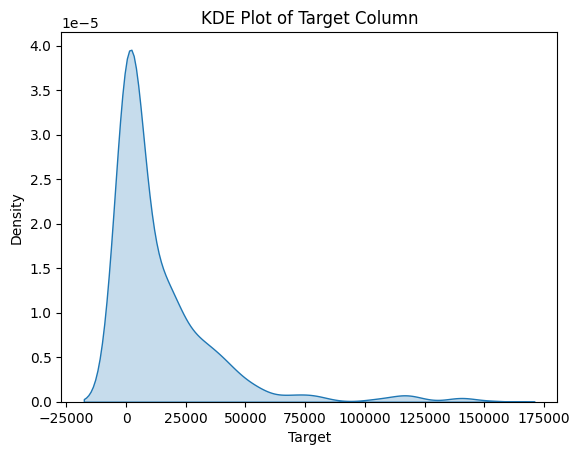

In [8]:
# KDE plot of the target column
sns.kdeplot(df['Price'], shade=True)

# Adding labels and title
plt.xlabel('Target')
plt.ylabel('Density')
plt.title('KDE Plot of Target Column')

# Show plot
plt.show()

### Analysis:
- The distribution is right-skewed (positively skewed), meaning that most prices are clustered toward the lower end, with a long tail extending to higher values.
- There is a high frequency of lower-priced items, and a few significantly higher-priced ones.
- There appear to be some negative values, which are anomalous and should be investigated or removed, since prices shouldn’t be negative.
- The peak is around 0 to 10,000, where the KDE curve reaches its maximum.
    -- This indicates the highest concentration of price values lies in the low-price range.




### 1.4 Clean-up & Tweak
 - Remove negative prices
 - Apply log transformation to stablize variance
 - Revisualize with box plot, histograme and KDE

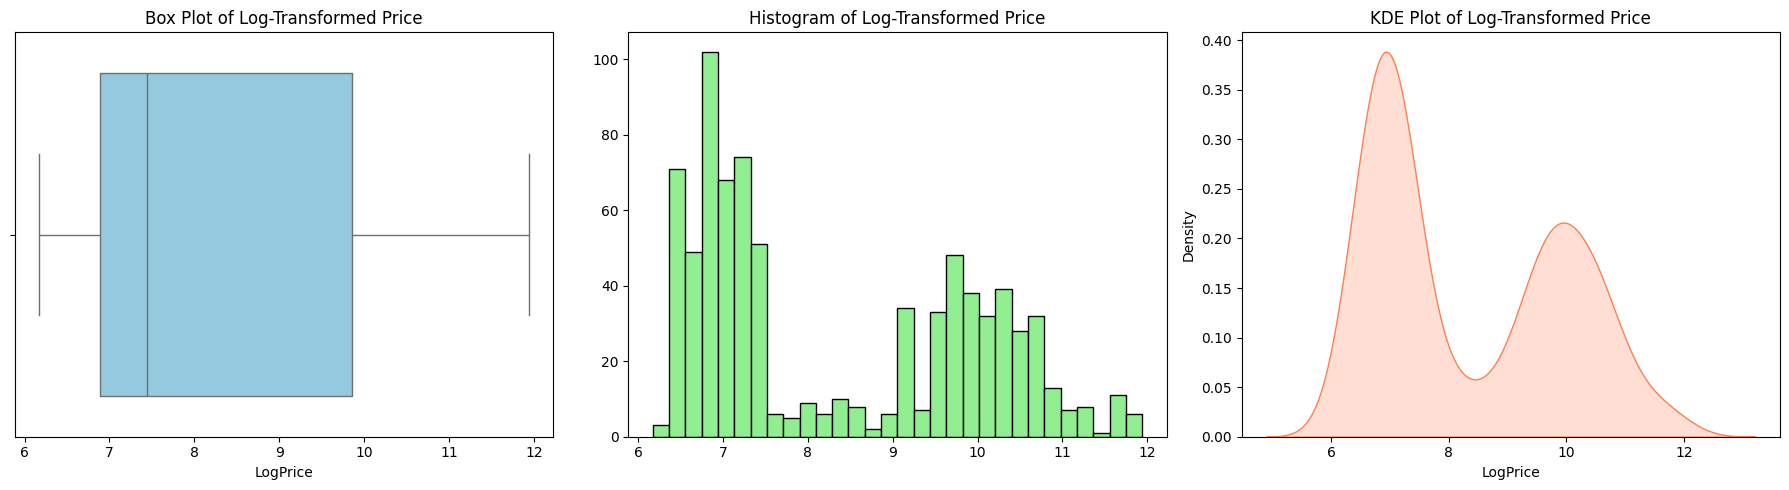

In [9]:
# Display basic info and check for negative prices
target_col = "Price" if "Price" in df.columns else df.columns[-1]
negative_prices = df[df[target_col] < 0]

# Remove rows with negative prices
df_cleaned = df[df[target_col] >= 0].copy()

# Apply log transformation
df_cleaned["LogPrice"] = np.log1p(df_cleaned[target_col])

# Plot box plot, histogram, and KDE of the log-transformed price
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot
sns.boxplot(x=df_cleaned["LogPrice"], ax=axes[0], color="skyblue")
axes[0].set_title("Box Plot of Log-Transformed Price")

# Histogram
axes[1].hist(df_cleaned["LogPrice"], bins=30, color="lightgreen", edgecolor="black")
axes[1].set_title("Histogram of Log-Transformed Price")

# KDE plot
sns.kdeplot(df_cleaned["LogPrice"], shade=True, ax=axes[2], color="coral")
axes[2].set_title("KDE Plot of Log-Transformed Price")

plt.tight_layout()
plt.show()

### 1.5 Post-Cleanup Analysis and Normalizing
 - No extreme outliers are visually prominent after transformation, suggesting that the log scale has effectively reduced the impact of outliers.
 - The median (line in the box) is slightly left-skewed, around 7.5–8.0, meaning most phones are priced modestly even on the log scale.
 - Histogram : One peak is around 6.8–7.5, likely representing lower-priced phones.
 - Histogram : Another smaller peak is around 10–11, indicating a secondary cluster of higher-end devices.
 - KDE Plot : Bimodal shape, with two density peaks : suggesting the price data includes two distinct product segments - possibly budget and premium phones.


### 1.6 Correlation & Analysis 

In [10]:
# Let's work with our new cleaned dataset, replace original df with cleaned version
df = df_cleaned.copy()

# Drop original 'Price' column
df.drop(columns=["Price"], inplace=True)

# Rename 'LogPrice' to 'Price'
df.rename(columns={"LogPrice": "Price"}, inplace=True)

# Select features and target variable for regression
# Replace the placeholder with the names of all the columns in the dataset except the target variable - 'Price'
features = ['Ratings', 'RAM', 'ROM', 'Mobile_Size', 'Primary_Cam', 'Selfi_Cam',
       'Battery_Power']

X = df[features]
Y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train[:5]

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power
788,4.5,6.0,128.0,6.39,48,13.0,3800
637,4.0,6.0,32.0,4.50,48,8.0,3000
444,3.9,6.0,32.0,4.50,48,11.0,3000
332,4.3,3.0,32.0,6.22,38,8.0,4030
291,3.8,6.0,32.0,4.54,25,8.0,3000


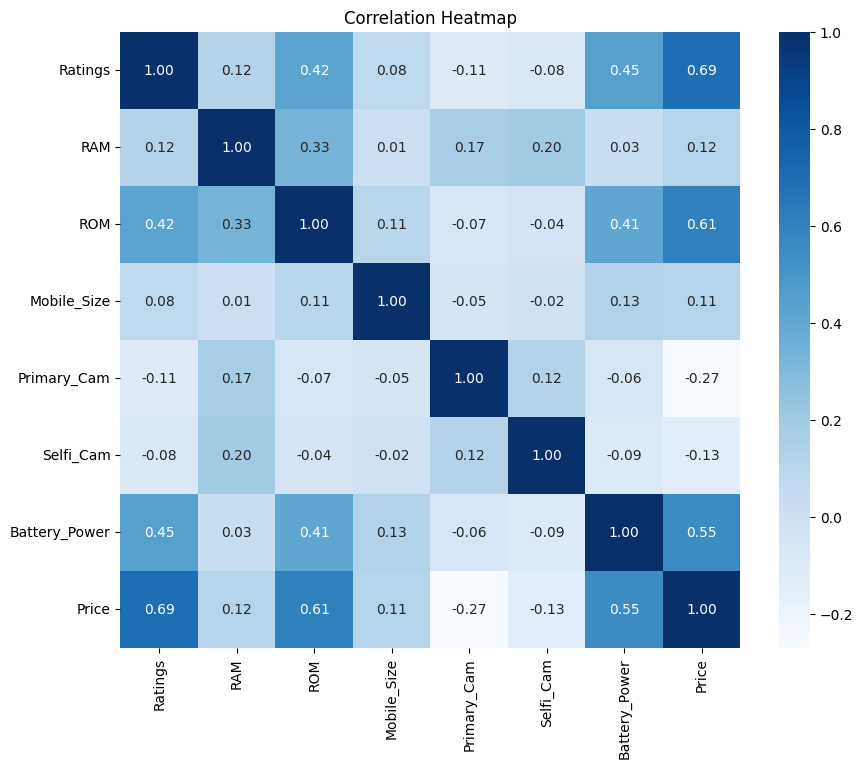

In [11]:
# Calculate the correlation matrix for the features
corr = df.corr()

# Set up the figure for the heatmap with a size of 10x8 inches
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### 1.7 Interpretation & Analysis

| Feature            | Correlation with `Price` | Interpretation                                                                                                 |
| ------------------ | ------------------------ | -------------------------------------------------------------------------------------------------------------- |
| **Ratings**        | **0.69**                 | Strong positive correlation — higher user ratings tend to align with higher price.                             |
| **ROM**            | **0.61**                 | Strong positive correlation — more internal storage correlates with higher prices (better cpu?).               |
| **Battery\_Power** | **0.55**                 | Moderate-to-strong positive correlation — bigger batteries often come in costlier phones.                      |
| **RAM**            | 0.12                     | Weak positive correlation — some relation, but not very strong.                                                |
| **Mobile\_Size**   | 0.11                     | Weak positive — screen size has little direct influence on price.                                              |
| **Selfi\_Cam**     | -0.13                    | Weak negative correlation — may indicate budget phones prioritize selfies less.                                |
| **Primary\_Cam**   | **-0.27**                | Mild negative correlation — surprisingly, higher main camera specs don’t strongly drive price in this dataset. |


🔁 Other Notable Relationships:
* Ratings and ROM → 0.42: Users may rate phones higher when they have more storage.
* ROM and Battery_Power → 0.41: Possibly due to shared architecture in mid/high-end phones.
* RAM and ROM → 0.33: Somewhat expected — phones with more RAM often have more ROM.

⚠️ Low or No Correlation
* Mobile_Size
* Selfi_Cam
* Primary_Cam 

These show little or negative correlation with price, which might be unexpected and worth further investigation (e.g., multicollinearity, nonlinear effects).

✅ Summary:
The strongest predictors of (log) Price are:

* Ratings
* ROM
* Battery_Power
* Features like RAM and Mobile_Size have limited predictive power.
* Primary and Selfie Cameras surprisingly correlate negatively 

### 1.8 Model Building
- `train_test_split()` helps to split the data into training and test datsets.
- `StandardScaler` from `sklearn.preprocessing` helps to scale the data before modelling.
- `OLS()` from `sm` (`statsmodels` library) helps to fit a linear regression model on the data. This is done as `model = sm.OLS(y_train, X_train).fit()`.
- `model.summary()` provides a detailed summary with all the metrics of the fitted linear regression model.

In [16]:
# Scale the train and test data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the data
X_train[:5]


array([[ 1.05672500e+00,  1.50829992e-03,  1.17842235e+00,
         2.07926298e-01,  1.41105799e-02,  9.23705036e-01,
         5.72882573e-01],
       [-3.03729343e-01,  1.50829992e-03, -6.04108782e-01,
        -2.83960196e-01,  1.41105799e-02, -1.84947268e-01,
        -2.83292851e-01],
       [-5.75820212e-01,  1.50829992e-03, -6.04108782e-01,
        -2.83960196e-01,  1.41105799e-02,  4.80244115e-01,
        -2.83292851e-01],
       [ 5.12543265e-01, -1.45777187e+00, -6.04108782e-01,
         1.63682539e-01, -8.69513114e-01, -1.84947268e-01,
         8.19033007e-01],
       [-8.47911081e-01,  1.50829992e-03, -6.04108782e-01,
        -2.73549900e-01, -2.01822392e+00, -1.84947268e-01,
        -2.83292851e-01]])

In [17]:
# Model Building using statsmodels library

# Add the intercept term
X = sm.add_constant(X)

# Splitting the data in 70:30 ratio of train to test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30 , random_state = 1)

model1 = sm.OLS(y_train, X_train).fit()

# Get the model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     162.8
Date:                Thu, 22 May 2025   Prob (F-statistic):          3.52e-130
Time:                        19:33:15   Log-Likelihood:                -767.80
No. Observations:                 564   AIC:                             1552.
Df Residuals:                     556   BIC:                             1586.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.551      0.002      0.998      -1.081       1.083
Ratings           1.8647      0.129     14.443      0.000       1.611       2.118
RAM              -0.0135      0.022     -0.607      0.544      -0.057       0.030
ROM               0.0105      0.001     11.362      0.000       0.009       0.012
Mobile_Size      -0.0041      0.009     -0.470      0.639      -0.021       0.013
Primary_Cam      -0.0228      0.004     -6.078      0.000      -0.030      -0.015
Selfi_Cam        -0.0080      0.009     -0.849      0.396      -0.026       0.010
Battery_Power     0.0004   4.87e-05      7.890      0.000       0.000       0.000
==============================================================================
Omnibus:                       12.412   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.847
Skew:                           0.287   Prob(JB):                     0.000984
Kurtosis:                       3.510   Cond. No.                     4.78e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1.9 Interpretation & Analysis
| Metric                    | Value             | Interpretation                                                        |
| ------------------------- | ----------------- | --------------------------------------------------------------------- |
| **R-squared**             | 0.667             | About **66.7%** of the variance in `Price` is explained by the model. |
| **Adjusted R-squared**    | 0.663             | Adjusts for number of predictors; still high → solid fit.             |
| **F-statistic / Prob(F)** | 159.2 / 2.33e-128 | Model is **statistically significant overall** — not random.          |


1. The model explains ~67% of the variance in price — a strong linear fit.
2. Ratings, ROM, Battery Power are positively and significantly associated with higher price.
3. Primary_Cam has a significant negative effect, which may reflect design tradeoffs or pricing strategies (e.g., high cam specs in budget phones).
4. RAM, Selfie Cam, and Mobile Size are not significant — they don’t meaningfully impact price in this model.
  

### 1.10 Multicollinearity Analysis

- **Variance Inflation Factor:**

  - VIF, or Variance Inflation Factor, is a measure used to detect the presence of multicollinearity in a regression model.
  - High VIF values indicate that a predictor variable is highly correlated with other predictors, which can make the coefficient estimates unstable and difficult to interpret.
  - Low VIF values suggest little to no multicollinearity.

- **Interpreting VIF values:**
  - **VIF = 1:** No multicollinearity; the predictor is not correlated with other variables.
  - **1 < VIF ≤ 5:** Low to moderate multicollinearity; generally acceptable but worth monitoring.
  - **VIF > 5:** Indicates moderate multicollinearity; may start affecting the reliability of the model's coefficients.
  - **VIF > 10:** High multicollinearity; problematic and often signals that the variable should be removed or combined with others.


In [ ]:
# Assuming df is your DataFrame and it is already loaded
# Remove non-numeric columns if any
df_numeric = df.select_dtypes(include=[float, int])

# Drop the target column 'Price' from VIF calculation
df_features = df_numeric.drop(columns=["Price"])

# Define a function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF for the dataset
vif_df = calculate_vif(df_features)
print(vif_df)

         Feature        VIF
0        Ratings  40.502259
1            RAM  11.506909
2            ROM   3.361623
3    Mobile_Size   3.065352
4    Primary_Cam  17.968744
5      Selfi_Cam   5.024353
6  Battery_Power  18.345003


### 1.11 Interpretation & Analysis

| Feature            | VIF       | Interpretation                                                                                                            |
| ------------------ | --------- | ------------------------------------------------------------------------------------------------------------------------- |
| **Ratings**        | **40.50** | 🚨 **Very high multicollinearity** — likely shares variance with one or more other predictors (e.g., ROM, Battery\_Power) |
| **Battery\_Power** | **18.35** | ⚠️ High — suggests redundancy with another feature                                                                        |
| **Primary\_Cam**   | **17.97** | ⚠️ High — strong linear relationship with other predictors                                                                |
| **RAM**            | **11.51** | ⚠️ Moderate-to-high multicollinearity                                                                                     |
| **Selfi\_Cam**     | 5.02      | ✅ Acceptable (borderline)                                                                                                 |
| **ROM**            | 3.36      | ✅ Low multicollinearity                                                                                                   |
| **Mobile\_Size**   | 3.07      | ✅ Low multicollinearity                                                                                                   |


In [20]:
#m Marginalize multicollinearity


from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

### 1.12 Random Forest Regressor

In [21]:

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
# Replace the placeholder with the code to fit the model using the model created - `rf_regressor.fit(X_train, y_train)`
rf_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Linear Regression Model Evaluation:
Mean Absolute Error (MAE): 0.17948364655087926
Mean Squared Error (MSE): 0.10959625846264297
R-squared (R2): 0.9548319499666832


### Interpretation & Analysis:

| Metric                        | Value      | Interpretation                                                                          |
| ----------------------------- | ---------- | --------------------------------------------------------------------------------------- |
| **MAE** (Mean Absolute Error) | `~0.0195`  | On average, predictions are only \~0.02 units off from actual (very low)                |
| **MSE** (Mean Squared Error)  | `~0.00125` | Squared error is tiny → very tight predictions                                          |
| **R² (R-squared)**            | **0.954**  | The model explains **95.4% of the variance** in the target variable — **excellent fit** |

### 1.13 Visualizing the result

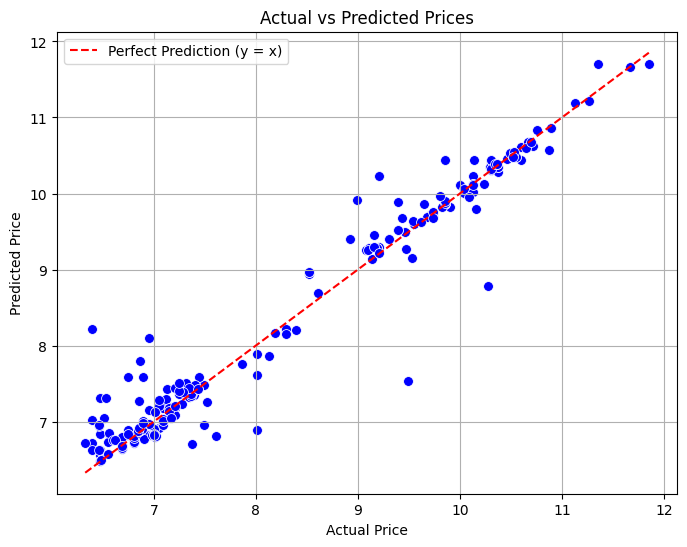

In [22]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=50)

# Add red diagonal reference line (perfect prediction line)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y = x)')

# Labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()


### Interpretation & Analysis:
* There's very little spread from the line — low variance in residuals.
* The alignment is linear and consistent across the range of values.
* Supports your earlier R² of ~0.95 — excellent predictive power.
   
   

   
 <hr>